# Exp6. Sentimental Analysis - RNN

### 텍스트를 숫자로 표현하기
텍스트는 그 자체로는 기호일 뿐이고, 텍스트가 내포하는 의미를 기호가 직접 내포하지 않는다.  
그렇기에 우리는 단어 사전을 만들어 단어와 단어의 의미를 나타내는 벡터를 짝지어 볼 수 있다. 
>i feel hungry  
i eat lunch  
now i feel happy

In [1]:
sentences = ['i feel hungry', 'i eat lunch', 'now i feel happy']

# split() 메서드로 단어 단위로 쪼개 보자.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
# 빈 딕셔너리 생성
index_to_word = {}

# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣는다.
index_to_word[0] = '<PAD>'  # 패딩용 단어
index_to_word[1] = '<BOS>'  # 문장의 시작지점
index_to_word[2] = '<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3] = 'i'
index_to_word[3] = 'i'
index_to_word[4] = 'feel'
index_to_word[5] = 'hungry'
index_to_word[6] = 'eat'
index_to_word[7] = 'lunch'
index_to_word[8] = 'now'
index_to_word[9] = 'happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
word_to_index = {word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
# 이제 이 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환한다.
print(word_to_index['feel'])

4


In [5]:
# 문장 1개를 활용할 딕셔너리와 주면, 단어 인덱스 리스트로 변환
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### Embedding 레이어
위에서 만든 벡터는 텍스트에 담긴 언어의 의미와 대응되는 벡터가 아닌, 임의로 부여된 단어의 순서에 불과하다.  
단어와 그 단어의 의미를 나타내는 벡터를 짝지어 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해 최적화해야 한다.  
Tensorfow, Pytorch 등의 딥러닝 프레임워크들은 이러한 의미 벡터 파라미터를 구현한 **Embedding 레이어**를 제공한다. 

In [9]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)
word_vector_dim = 4  # 4차원의 워드 벡터를 가정

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
# 주의! Embedding 레이어의 input이 되는 문장 벡터는 그 길이가 일정해야 한다!
# 아래 코드를 통해 문장 벡터 뒤에 <pad>를 추가해 길이를 일정하게 맞춘다!
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.04614459 -0.01872499 -0.0093254  -0.03130987]
  [-0.00157475  0.01702125  0.03673667  0.020668  ]
  [-0.01727836 -0.0365799  -0.00639813  0.00749482]
  [-0.03550913 -0.02033593 -0.00361381 -0.012744  ]
  [ 0.00682653  0.04289414  0.04266309  0.00174015]]

 [[-0.04614459 -0.01872499 -0.0093254  -0.03130987]
  [-0.00157475  0.01702125  0.03673667  0.020668  ]
  [-0.04226501  0.02292699 -0.0214425  -0.01398691]
  [-0.04074789 -0.02181323  0.01800436 -0.00130145]
  [ 0.00682653  0.04289414  0.04266309  0.00174015]]

 [[-0.04614459 -0.01872499 -0.0093254  -0.03130987]
  [-0.01611158 -0.04577921  0.0384709  -0.04793768]
  [-0.00157475  0.01702125  0.03673667  0.020668  ]
  [-0.01727836 -0.0365799  -0.00639813  0.00749482]
  [-0.01464113  0.03252186  0.02412741  0.00850205]]], shape=(3, 5, 4), dtype=float32)


output의 `shape=(3, 5, 4)`는 순서대로 입력문장의 개수, 입력문장의 최대 길이, 워드 벡터의 차원 수를 의미한다.

### 시퀀스 데이터를 다루는 RNN
텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 `RNN(Recurrent Neural Network)`이다. 이는 시퀀스 형태의 데이터를 처리하기에 죄적의 모델로 알려져있다.  
RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었다.

In [10]:
# RNN 모델을 사용해 이전 스텝의 텍스트 데이터를 처리하는 예제
vocab_size = 10
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 널리 쓰이는 RNN인 LSTM 레이어 사용, LSTM state 벡터의 차원 수는 8로 설정
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### 1-D CNN(Convolution Neural Network) vs RNN
텍스트를 처리하기 위해 RNN이 아니라 `1-D CNN`을 사용할 수도 있다.  
`1-D CNN`은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캔하면서 7단어 이내에서 발견되는 특징을 추출해 그것으로 문장을 분류한다.  
이 방식도 텍스트를 처리하는데 RNN 못지않은 효율을 보여주는데, RNN 계열보다 병렬처리가 효율적이기 대문에 학습 속도도 훨씬 빠르다는 장점이 있다. 

In [11]:
vocab_size = 10
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

아주 간단히는 `GlobalMaxPooling1D()` 레이어 하나만 사용하는 방법도 생각해 볼 수 있다.  
이 방식은 전체 문장 중 가장 중요한 단어만 피처로 추추래 그것으로 문장의 긍정 / 부정을 평가하는 방식인데, 의외로 성능이 잘 나올 수도 있다고 한다.

In [12]:
vocab_size = 10
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


1-D CNN과 RNN 레이어를 섞는다던가, FFN(FeedFoward Network) 레이어만으로 구성하거나, 최근 주목받는 Trnsformer 레이어를 사용하는 등 다양한 시도가 가능하다. 

## IMDB 영화 리뷰 감성분석
### (1) IMDB 데이터셋 분석
IMDB Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로, 긍정은 1, 부정은 0의 라벨이 달려있다.  
절반인 25000개가 훈련용 데이터, 나머지를 테스트용 데이터로 사용하도록 지정되어 있다. 

In [13]:
imdb = tf.keras.datasets.imdb

# 단어사전에 등재할 단어의 개수를 10000으로 지정하면, 그 개수만큼의 word_to_index 딕셔너리까지 생성된 상태로 데이터셋 생성
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [14]:
print(x_train[0])
print('라벨: ', y_train[0])
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드했음을 알 수 있다. 

In [15]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])

the
1


`word_to_index`, `index_to_word`는 다음과 같이 보정되어야 한다. (Tensorflow 튜토리얼의 가이드를 참고했다)  
`word_to_index`는 IMDB 텍스트 데이터셋의 단어 출현 빈도 기준 내림차순 정렬되어 있다. 

In [16]:
# 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있다.
word_to_index = {k:(v+3) for k, v in word_to_index.items()}

# 처음 몇 개의 인덱스는 사전에 정의되어 있다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])
print(word_to_index['the'])
print(index_to_word[4])

<BOS>
4
the


In [17]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

`pad_sequences`를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안 된다.  
문장의 최대 길이 `maxlen`의 값 설정도 전체 모델 성능에 영향을 미친다. 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해보는 것이 좋다.

In [18]:
total_data_text = list(x_train) + list(x_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장 길이 평균: ', np.mean(num_tokens))
print('문장 길이 최대: ', np.max(num_tokens))
print('문장 길이 표준편차: ', np.std(num_tokens))

# 예시로, 최대 길이를 *(평균 + 2 * 표준편차)로 설정할 경우
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장 길이 평균:  234.75892
문장 길이 최대:  2494
문장 길이 표준편차:  172.91149458735703
pad_sequences maxlen:  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함된다.


또 한 가지 유의해야 할 점은 padding 방식을 post와 pre 중 어느 쪽으로 정하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다.  
두 가지 방식을 한 번씩 다 적용해서 그 결과를 비교해보자. 

In [19]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=maxlen)

print(x_train.shape)

(25000, 580)


>RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다.  
따라서 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다. 

### (2) 딥러닝 모델 설계와 훈련

In [20]:
# 모델 설계
vocab_size = 10000
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼 파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리해 validation set으로 사용하자. 

In [21]:
# validation set 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [22]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
30/30 [==============================] - 4s 31ms/step - loss: 0.6924 - accuracy: 0.5074 - val_loss: 0.6910 - val_accuracy: 0.5588
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6808 - accuracy: 0.5402 - val_loss: 0.6741 - val_accuracy: 0.6983
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6242 - accuracy: 0.6744 - val_loss: 0.5698 - val_accuracy: 0.7601
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4907 - accuracy: 0.8399 - val_loss: 0.4646 - val_accuracy: 0.8426
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3620 - accuracy: 0.9102 - val_loss: 0.3759 - val_accuracy: 0.8695
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2326 - accuracy: 0.9447 - val_loss: 0.3306 - val_accuracy: 0.8701
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1454 - accuracy: 0.9643 - val_loss: 0.3688 - val_accuracy: 0.8635
Epoch 8/20
30

In [23]:
# test set으로 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.6947 - accuracy: 0.8382
[0.6947020888328552, 0.83815997838974]


`model.fit()` 과정 중 train / validation loss, accuracy 등이 epoch마다 history 변수에 저장되어 있다.   
이 데이터를 시각화하면, 딥러닝 학습일 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 아이디어를 얻을 수 있는 자료가 된다.

In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


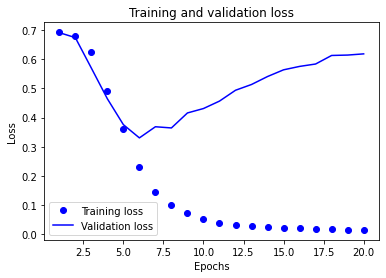

In [25]:
# 모델 학습 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점, b는 파란 실선
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

위 그래프를 보면 몇 epoch까지의 학습이 적절한지 최적점을 추정할 수 있다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 학습은 무의미해진다. 

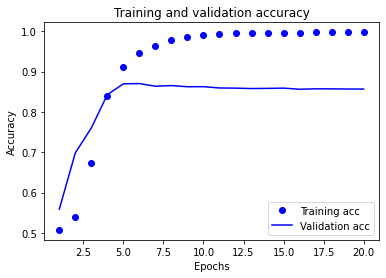

In [26]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 Training and validation accuracy를 그려봐도 유사한 인사이트를 얻을 수 있다. 

### (3) Word2Vec 적용
라벨링 비용이 많이 드는 감성분석의 비용을 줄이면서, 정확도를 크게 높일 수 있는 자연어처리 기법으로  
단어의 특성을 저차원 벡터값으로 표현할 수 있는 `워드 임베딩(word embedding)` 기법이 있다.  
앞서 사용했던 model의 첫 번재 레이어가 Embedding 레이어였는데, 이 레이어는 사전의 단어 개수 * 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였다.  
만약 앞의 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 워드 벡터들도 의미 공간 상에 유의미한 형태로 학습되었을 것이다. 확인해보자.

In [27]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  # vocab_size, embedding_dim

(10000, 16)


In [28]:
# 학습한 embedding 파라미터를 파일로 저장
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 어떤 사이즈로 기재할지의 타이틀.

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
# gensim에서 제공하는 패키지로, 위에서 만든 임베딩 파라미터를 익어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.0115478 , -0.00109054,  0.09078266,  0.04226822, -0.03513872,
       -0.04965927, -0.07862715, -0.07379095,  0.05347811, -0.00402092,
        0.01751629, -0.02840046,  0.02481056,  0.07604838, -0.01475856,
       -0.00540159], dtype=float32)

워드 벡터가 의미 벡터 공간 상에 유의미하게 학습되었는지 확인하기 위해, 단어를 하나 주고 가장 유사한 단어와 그 유사도를 확인해 볼 수 있다.

In [30]:
word_vectors.similar_by_word("love")

[('larger', 0.8839967846870422),
 ('believable', 0.8710741400718689),
 ('fiction', 0.861591637134552),
 ('crooks', 0.8607564568519592),
 ('athletic', 0.8585770726203918),
 ('inspector', 0.8447098135948181),
 ('discovers', 0.8367086052894592),
 ('ace', 0.8348056674003601),
 ('delirious', 0.8339557647705078),
 ('psychologically', 0.8322232365608215)]

감성 분류 태스크를 잠깐 학습한 것으로는 워드 벡터가 유의미하게 학습되기 어려운 것 같다.  
이제 구글에서 제공하는 `Word2Vec`이라는 사전학습된 워드 임베딩 모델을 활용해보자.  
>Word2Vec은 1억 개로 구성된 Google News dataset을 바탕으로 학습되었다. 총 300만 개의 단어를 각각 300차원의 벡터로 표현했다. 

In [31]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
# 300dim의 벡터로 이루어진 300만 개의 단어를 모두 메모리에 로딩하면 실습환경에 따라 메모리 에러가 날 수 있다. 
# KeyedVector.load_word2vec_format 메서드로 가장 많이 사용되는 상위 100만개만 limit으로 설정해 로드
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [32]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

앞에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체해 다시 학습시켜보자. 

In [33]:
vocab_size = 10000
word_vector_dim = 300
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 차례로 카피
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [37]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 300

# 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen,
                                   trainable=True))  # trainable=True면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [38]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 4s 82ms/step - loss: 0.6982 - accuracy: 0.5075 - val_loss: 0.6857 - val_accuracy: 0.5364
Epoch 2/20
30/30 [==============================] - 2s 69ms/step - loss: 0.6647 - accuracy: 0.6067 - val_loss: 0.6517 - val_accuracy: 0.6296
Epoch 3/20
30/30 [==============================] - 2s 69ms/step - loss: 0.5829 - accuracy: 0.7221 - val_loss: 0.5269 - val_accuracy: 0.7691
Epoch 4/20
30/30 [==============================] - 2s 69ms/step - loss: 0.4179 - accuracy: 0.8307 - val_loss: 0.3794 - val_accuracy: 0.8409
Epoch 5/20
30/30 [==============================] - 2s 70ms/step - loss: 0.2819 - accuracy: 0.8919 - val_loss: 0.3162 - val_accuracy: 0.8661
Epoch 6/20
30/30 [==============================] - 2s 70ms/step - loss: 0.2006 - accuracy: 0.9293 - val_loss: 0.3165 - val_accuracy: 0.8621
Epoch 7/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1456 - accuracy: 0.9551 - val_loss: 0.3003 - val_accuracy: 0.8759
Epoch 8/20
30

In [39]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.5264 - accuracy: 0.8638
[0.5264298915863037, 0.8637999892234802]
